In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import requests 
import random

%matplotlib inline

In [2]:
data_dir = "D:\\Downloads\\citadel-datathon-fall-2020"
DATA_ROOT = "D:\\Downloads\\citadel-datathon-fall-2020"

In [3]:
# load in data
movies_csv = pd.read_csv(os.path.join(DATA_ROOT, 'movies.csv'))
ratings_csv = pd.read_csv(os.path.join(DATA_ROOT, 'ratings.csv'))

oscars_csv = pd.read_csv(os.path.join(DATA_ROOT, 'the_oscar_award.csv'))
tags_csv = pd.read_csv(os.path.join(DATA_ROOT, 'tags.csv'))

In [4]:
oscars_csv.dropna(subset=['film'])
oscar_cer2day = pd.read_csv('oscar_cer2day.csv')
oscar_cer2day['day'] = pd.to_datetime(oscar_cer2day['day'])
oscar_cer2day = oscar_cer2day.set_index('ceremony')

In [5]:
sorted_ratings = ratings_csv.sort_values(by='timestamp').reset_index(drop=True)
s_ratings_grouped = sorted_ratings.groupby('movieId')

In [6]:
sorted_ratings['datetime'] = pd.to_datetime(sorted_ratings['timestamp'], unit='s')

In [7]:
ratings_t = sorted_ratings
ratings_t['cum_rating'] = s_ratings_grouped['rating'].cumsum()
ratings_t['cum_count'] = s_ratings_grouped['rating'].cumcount()
ratings_t['cur_rating'] = ratings_t['cum_rating'] / (ratings_t['cum_count'] + 1)

In [8]:
ratings_t['win_rating'] = s_ratings_grouped['rating'] \
    .rolling(1000, min_periods=1).mean().reset_index(0)['rating']
ratings_t

,userId,movieId,rating,timestamp,datetime,cum_rating,cum_count,cur_rating,win_rating
0,56769,1176,4.0,789652004,1995-01-09 11:46:44,4.0,0,4.000000,4.000000
1,237556,1079,3.0,789652009,1995-01-09 11:46:49,3.0,0,3.000000,3.000000
2,237556,47,5.0,789652009,1995-01-09 11:46:49,5.0,0,5.000000,5.000000
3,237556,21,3.0,789652009,1995-01-09 11:46:49,3.0,0,3.000000,3.000000
4,150485,39,5.0,822873600,1996-01-29 00:00:00,5.0,0,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...
27753439,280481,2294,2.0,1537945121,2018-09-26 06:58:41,41980.0,12973,3.235702,2.917000
27753440,280481,2355,3.0,1537945123,2018-09-26 06:58:43,91256.0,25520,3.575722,3.427000
27753441,280481,494,3.0,1537945127,2018-09-26 06:58:47,48935.5,14503,3.373931,3.093500
27753442,82922,53519,4.0,1537945130,2018-09-26 06:58:50,16718.0,4694,3.560809,3.593500


In [9]:
def plot_movie(movie_id, ax=None):
    ax = ax if ax else plt.gca()
    movie_data = ratings_t[ratings_t['movieId'] == movie_id]
    f_movie_data = movie_data[movie_data['cum_count'] > 50]
    sns.lineplot(x=f_movie_data['cum_count'], y=f_movie_data['win_rating'], label='win_rating', ax=ax, alpha=0.5)
    sns.lineplot(x=f_movie_data['cum_count'], y=f_movie_data['cur_rating'], label='cur_rating', ax=ax)
    ax.set_title(movies_csv.loc[movies_csv.movieId == movie_id]['title'].iloc[0])
    def fmt(i, pos):
        if i < 0:
            return ""
        rows = movie_data[movie_data['cum_count'] == i]
        if len(rows)  < 1:
            return i
        return datetime.fromtimestamp(rows.iloc[0]['timestamp'])\
                .strftime("%m-%Y")
    ax.xaxis.set_major_formatter(fmt)

In [22]:
def plot_movie2(movie_id, ax=None, fmt=True):
    ax = ax if ax else plt.gca()
    movie_data = ratings_t[ratings_t['movieId'] == movie_id]
    f_movie_data = movie_data[movie_data['cum_count'] > 50] if movie_data.shape[0] > 20000 else movie_data
    sns.lineplot(x=f_movie_data['datetime'], y=f_movie_data['win_rating'], label='win_rating', ax=ax, alpha=0.5)
    sns.lineplot(x=f_movie_data['datetime'], y=f_movie_data['cur_rating'], label='cur_rating', ax=ax)
    ax.set_title(movies_csv.loc[movies_csv.movieId == movie_id]['title'].iloc[0])
    
    magic = ax.xaxis.get_major_formatter()
    if fmt:
        ax.xaxis.set_major_formatter(lambda x, _: pd.to_datetime(x, unit='D').strftime('%m-%Y'))

In [11]:
movies_adj = movies_csv

def purify_oscar_title(x):
    x = str(x).replace('&', 'and')
    if x.startswith("The "):
        return x[4:]
    if x.startswith("A "):
        return x[2:]
    return x

def purify_title(x):
    x = ' '.join(x.split()[:-1])
    x = purify_oscar_title(x)
    return x.replace(", The", "").replace(", A", "")
        
movies_adj['pure_title'] = movies_adj['title'].apply(purify_title)


oscars_csv['film_p'] = oscars_csv['film'].apply(purify_oscar_title)

In [47]:
def plot_oscars(movie_id, ax):
    movie_title = movies_csv.loc[movies_csv.movieId == movie_id]['title'].iloc[0]
    movie_title = purify_title(movie_title)
    oscars = oscars_csv[oscars_csv['film_p'] == movie_title]['ceremony']
    events = (oscars.apply(lambda x: oscar_cer2day.loc[x]['day']) - pd.Timestamp.utcfromtimestamp(0)).dt.days
    print(events)
    sns.rugplot(x=events, ax=ax)
    

54241


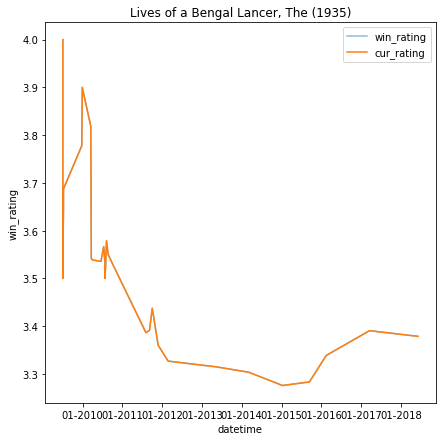

In [25]:
x = movies_adj[movies_adj['pure_title'] == oscars_csv.iloc[401]['film_p']]
if len(x):
    id = x.iloc[0]['movieId']
    print(id)
    fig, ax = plt.subplots(figsize=(7,7))
    plot_movie2(id, ax=ax, fmt=True)
    #plot_oscars(id, ax=ax)

In [20]:
ratings_t[ratings_t.movieId == 43383]

,userId,movieId,rating,timestamp,datetime,cum_rating,cum_count,cur_rating,win_rating
17020279,134596,43383,3.5,1266627564,2010-02-20 00:59:24,3.5,0,3.500000,3.500000
17024812,191028,43383,4.0,1266784762,2010-02-21 20:39:22,7.5,1,3.750000,3.750000
17025564,117490,43383,3.5,1266796510,2010-02-21 23:55:10,11.0,2,3.666667,3.666667
17029688,146942,43383,2.5,1266918257,2010-02-23 09:44:17,13.5,3,3.375000,3.375000
17055887,227150,43383,3.5,1267921594,2010-03-07 00:26:34,17.0,4,3.400000,3.400000
22514878,123100,43383,3.5,1450164107,2015-12-15 07:21:47,20.5,5,3.416667,3.416667
23170714,187986,43383,4.0,1459091573,2016-03-27 15:12:53,24.5,6,3.500000,3.500000
27001466,95727,43383,3.0,1521848351,2018-03-23 23:39:11,27.5,7,3.437500,3.437500


In [32]:
ratings_count = ratings_t.groupby(['movieId']).size()

In [39]:
x = ratings_count[ratings_count > 100].sort_values(ascending=False)
x

movieId
318       97999
356       97040
296       92406
593       87899
2571      84545
          ...  
116817      101
8903        101
27049       101
5208        101
8598        101
Length: 10448, dtype: int64

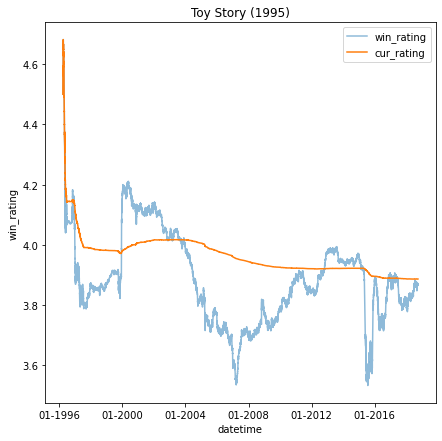

In [53]:
id = 1
fig, ax = plt.subplots(figsize=(7,7))
plot_movie2(id, ax=ax)
#plot_oscars(id, ax=ax)

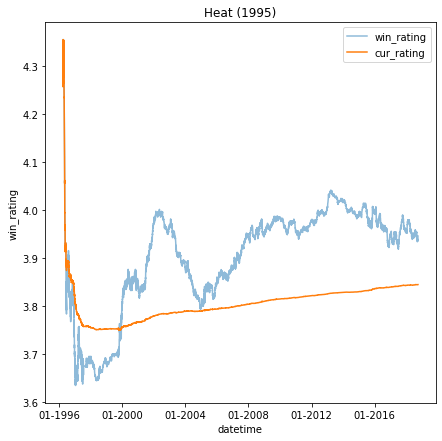

In [58]:
id = 6
fig, ax = plt.subplots(figsize=(7,7))
plot_movie2(id, ax=ax)
#plot_oscars(id, ax=ax)

In [42]:
x.sample(n=10)

movieId
3535     12952
1663      9581
3577       310
4275      1361
2864       191
71468      442
3667       145
55274      896
4645       270
2858     60820
dtype: int64